### Imports

In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from os import listdir, environ
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
print(tf.version)
print(tf.config.list_physical_devices('GPU'))

<module 'tensorflow._api.v2.version' from 'C:\\Users\\nicol\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# For reproducible results
seed = 42
environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)  
#tf.keras.utils.set_random_seed(42)  
#tf.config.experimental.enable_op_determinism()

### Data 

In [3]:
# Constants
val_size = 0.2
data_path_healthy = 'public_healthy'
data_path_unhealthy = 'public_unhealthy'

In [4]:
# Loads images from folder and converts to nparray
def load_images(path):
    files = os.listdir(path)
    images = []
    
    for file in files:
        file_path = os.path.join(path, file)
        image = cv2.imread(file_path)
        
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_rgb = image.astype(np.float32)
            images.append(image_rgb)
        else:
            print(f"Unable to load image: {jpg_file}")

    return np.array(images)

In [5]:
# Read the (cleaned) data
plants_healthy = load_images(data_path_healthy)
plants_unhealthy = load_images(data_path_unhealthy)

# Merge plant data sets
X = np.concatenate([plants_healthy, plants_unhealthy], axis=0)

# Create labels: 0 for 'healthy', 1 for 'unhealthy'
y = np.concatenate([np.zeros(len(plants_healthy)), np.ones(len(plants_unhealthy))], axis=0)

# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y, num_classes=2)

# Split into train and validation (hidden test set on codalab)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=val_size, stratify=np.argmax(y,axis=1))

# Convert labels to categorical format using one-hot encoding
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(4000, 96, 96, 3) (1000, 96, 96, 3) (4000, 2) (1000, 2)


In [6]:
# Create an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,        
    zoom_range=0.2,          
    horizontal_flip=True,    
    fill_mode='nearest'      
)

datagen.fit(X_train, seed=seed)

### Transfer Learning

In [7]:
# Model parameters 
input_shape = X.shape[1:] 
output_shape = y.shape[1] 
batch_size = 64     
epochs = 1000

In [8]:
## Use the ConvNeXtLarge model, pretrained on imagenet
convnext = tfk.applications.convnext.ConvNeXtLarge(
    include_top=False,
    include_preprocessing=True,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
)

In [9]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
convnext.trainable = False

# Create an input layer with the shape of our images
inputs = tfk.Input(X_train.shape[1:])

# Connect ConvNeXtXLarge to the input
x = convnext(inputs)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional)  (None, 1536)             196230336 
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 196,233,410
Trainable params: 3,074
Non-trainable params: 196,230,336
_________________________________________________________________


In [10]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history_tl = model.fit(
    datagen.flow(X_train, y_train, batch_size, seed=seed),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

Epoch 1/1000
63/63 [==============================] - 30s 250ms/step - loss: 0.6310 - accuracy: 0.6810 - val_loss: 0.5757 - val_accuracy: 0.6970
Epoch 2/1000
63/63 [==============================] - 11s 174ms/step - loss: 0.4703 - accuracy: 0.7753 - val_loss: 0.5239 - val_accuracy: 0.7500
Epoch 3/1000
63/63 [==============================] - 11s 174ms/step - loss: 0.4167 - accuracy: 0.8062 - val_loss: 0.4234 - val_accuracy: 0.8040
Epoch 4/1000
63/63 [==============================] - 11s 173ms/step - loss: 0.4066 - accuracy: 0.8148 - val_loss: 0.4082 - val_accuracy: 0.8020
Epoch 5/1000
63/63 [==============================] - 11s 174ms/step - loss: 0.3834 - accuracy: 0.8280 - val_loss: 0.3942 - val_accuracy: 0.8240
Epoch 6/1000
63/63 [==============================] - 11s 169ms/step - loss: 0.3867 - accuracy: 0.8313 - val_loss: 0.4003 - val_accuracy: 0.8170
Epoch 7/1000
63/63 [==============================] - 10s 166ms/step - loss: 0.3797 - accuracy: 0.8295 - val_loss: 0.4257 - val_ac

63/63 [==============================] - 11s 166ms/step - loss: 0.3133 - accuracy: 0.8610 - val_loss: 0.3581 - val_accuracy: 0.8570
Epoch 58/1000
63/63 [==============================] - 11s 166ms/step - loss: 0.3043 - accuracy: 0.8705 - val_loss: 0.3748 - val_accuracy: 0.8450
Epoch 59/1000
63/63 [==============================] - 11s 169ms/step - loss: 0.3122 - accuracy: 0.8668 - val_loss: 0.3518 - val_accuracy: 0.8520


### Fine Tuning

In [11]:
# Set all ConvNeXtLarge layers as trainable
model.get_layer('convnext_large').trainable = True

# Re-compile the model with small learning rate, use lower patience for early stop
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics='accuracy')
early_stopping.patience = 10

# Fine tune the model
history_ft = model.fit(
    datagen.flow(X_train, y_train, batch_size, seed=seed),
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the fine tuned model
model.save('mark_V.h5')
model.save('mark_V')

Epoch 1/1000
63/63 [==============================] - 51s 531ms/step - loss: 0.3048 - accuracy: 0.8712 - val_loss: 0.3370 - val_accuracy: 0.8570
Epoch 2/1000
63/63 [==============================] - 29s 457ms/step - loss: 0.2667 - accuracy: 0.8800 - val_loss: 0.3021 - val_accuracy: 0.8780
Epoch 3/1000
63/63 [==============================] - 29s 459ms/step - loss: 0.2229 - accuracy: 0.9062 - val_loss: 0.2871 - val_accuracy: 0.8850
Epoch 4/1000
63/63 [==============================] - 29s 458ms/step - loss: 0.2077 - accuracy: 0.9110 - val_loss: 0.2667 - val_accuracy: 0.8960
Epoch 5/1000
63/63 [==============================] - 29s 457ms/step - loss: 0.1836 - accuracy: 0.9260 - val_loss: 0.2664 - val_accuracy: 0.8930
Epoch 6/1000
63/63 [==============================] - 28s 450ms/step - loss: 0.1608 - accuracy: 0.9375 - val_loss: 0.2671 - val_accuracy: 0.8960
Epoch 7/1000
63/63 [==============================] - 29s 458ms/step - loss: 0.1498 - accuracy: 0.9420 - val_loss: 0.2348 - val_ac

INFO:tensorflow:Assets written to: mark_V\assets


INFO:tensorflow:Assets written to: mark_V\assets


### Evaluation

In [12]:
def evaluate(history, training_step):
    
    # Find the epochs with lowest validation loss respectively highest validation accuracy
    best_loss_epoch = np.argmin(history['val_loss'])
    best_acc_epoch = np.argmax(history['val_accuracy'])

    # Plot training and validation performance metrics
    plt.figure(figsize=(20, 5))

    # Plot training and validation loss
    plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
    plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
    plt.plot(best_loss_epoch, history['val_loss'][best_loss_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title(f'{training_step}: Categorical Crossentropy')
    plt.grid(alpha=0.3)

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy, highlighting the best epoch
    plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
    plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
    plt.plot(best_acc_epoch, history['val_accuracy'][best_acc_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title(f'{training_step}: Accuracy')
    plt.grid(alpha=0.3)

    plt.show()

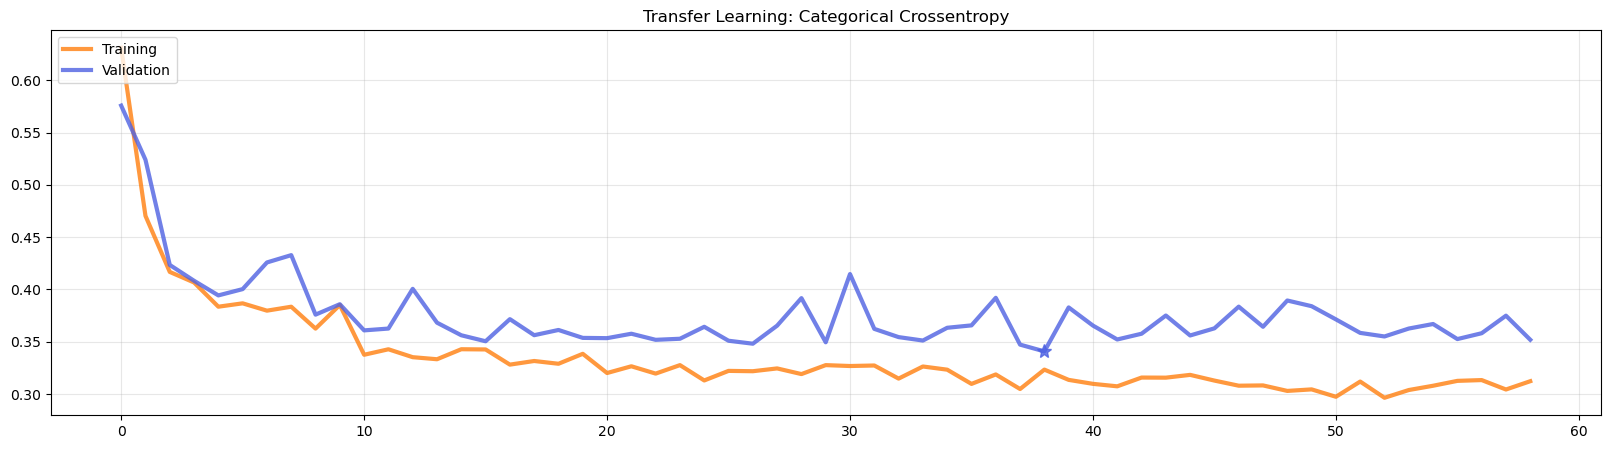

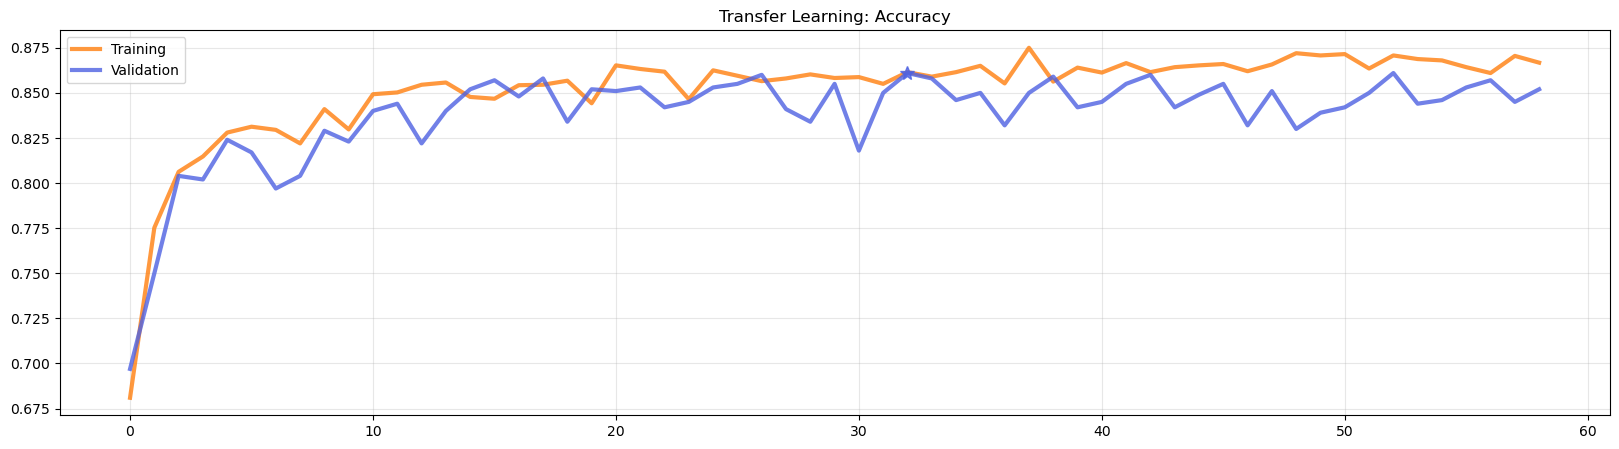

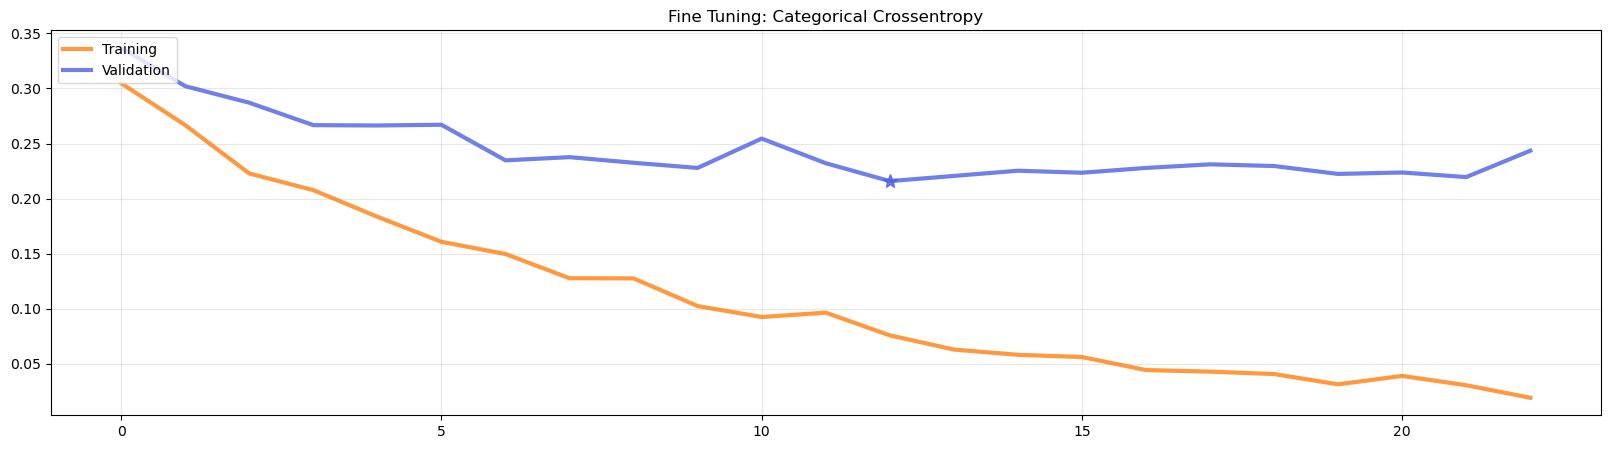

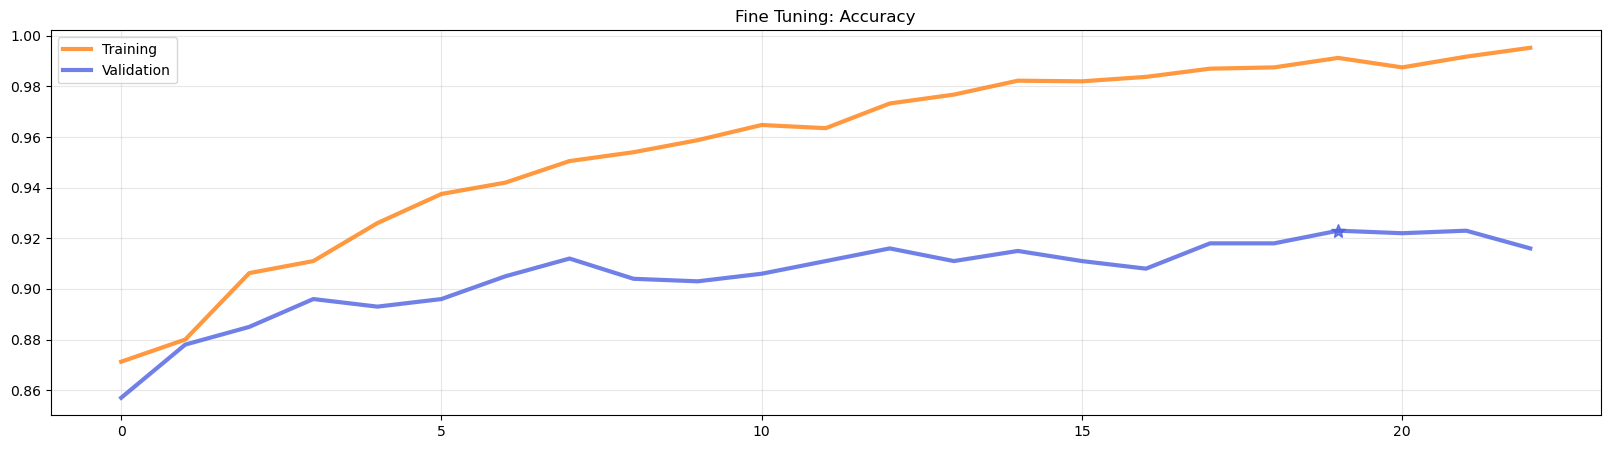

In [13]:
# Evaluate transfer learning and fine tuning
evaluate(history_tl, 'Transfer Learning')
evaluate(history_ft, 'Fine Tuning')

In [14]:
# Calculate validation accuracy on final model
val_pred = model.predict(X_val, verbose=0)
val_pred = np.argmax(val_pred, axis=-1)
val_true = np.argmax(y_val, axis=-1)
print('Validation accuracy: ', accuracy_score(val_true, val_pred))

Validation accuracy:  0.916
